# **Implement LINE, HOPE, APP, Struc2Vec and Role2Vec with Football dataset**

# metapath2vec: Scalable Representation Learning for Heterogeneous Networks


The file football.gml contains the network of American football games
between Division IA colleges during regular season Fall 2000, as compiled
by M. Girvan and M. Newman.  The nodes have values that indicate to which
conferences they belong.  The values are as follows:

  0 = Atlantic Coast
  1 = Big East
  2 = Big Ten
  3 = Big Twelve
  4 = Conference USA
  5 = Independents
  6 = Mid-American
  7 = Mountain West
  8 = Pacific Ten
  9 = Southeastern
 10 = Sun Belt
 11 = Western Athletic

If you make use of these data, please cite M. Girvan and M. E. J. Newman,
Community structure in social and biological networks,
Proc. Natl. Acad. Sci. USA 99, 7821-7826 (2002).

Correction: Two edges were erroneously duplicated in this data set, and
have been removed (21 SEP 2014)

BrighamYoung         12
FloridaState         12
Iowa                 12
KansasState          12
NewMexico            11
TexasTech            12
PennState            12
SouthernCalifornia   12
ArizonaState         11
SanDie

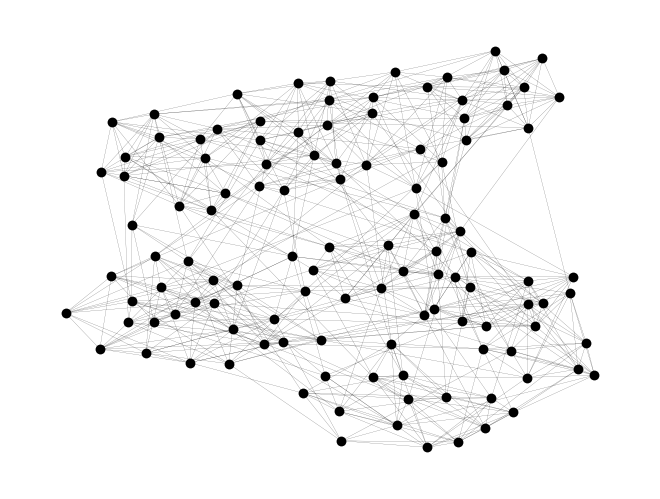

In [1]:
import urllib.request
import io
import zipfile

import matplotlib.pyplot as plt
import networkx as nx

url = "http://www-personal.umich.edu/~mejn/netdata/football.zip"

sock = urllib.request.urlopen(url)  # open URL
s = io.BytesIO(sock.read())  # read into BytesIO "file"
sock.close()

zf = zipfile.ZipFile(s)  # zipfile object
txt = zf.read("football.txt").decode()  # read info file
gml = zf.read("football.gml").decode()  # read gml data
# throw away bogus first line with # from mejn files
gml = gml.split("\n")[1:]
G = nx.parse_gml(gml)  # parse gml data

print(txt)
# print degree for each team - number of games
for n, d in G.degree():
    print(f"{n:20} {d:2}")

options = {"node_color": "black", "node_size": 50, "linewidths": 0, "width": 0.1}

pos = nx.spring_layout(G, seed=1969)  # Seed for reproducible layout
nx.draw(G, pos, **options)
plt.show()

### Word2Vec

In [2]:
import numpy as np
import networkx as nx
import random
import threading
from collections import defaultdict

class Word2Vec:
    def __init__(self, vector_size=100, window=5, negative=5, alpha=0.025, min_count=1, sg=1, iter=5, num_threads=4):
        self.window = window
        self.negative = negative
        self.alpha = alpha
        self.min_count = min_count
        self.sg = sg
        self.iter = iter
        self.num_threads = num_threads
        self.vocab = defaultdict(int)
        self.index2word = []
        self.word2index = {}
        self.syn0 = None
        self.syn1neg = None
        self.table = None
        self.table_size = int(1e8)
        self.vector_size = vector_size
        self.size = vector_size
    
    def build_vocab(self, sentences):
        for sentence in sentences:
            for word in sentence:
                self.vocab[word] += 1
        self.vocab = {word: freq for word, freq in self.vocab.items() if freq >= self.min_count}
        self.index2word = list(self.vocab.keys())
        self.word2index = {word: idx for idx, word in enumerate(self.index2word)}
    
    def init_net(self):
        vocab_size = len(self.vocab)
        self.syn0 = (np.random.rand(vocab_size, self.size) - 0.5) / self.size
        self.syn1neg = np.zeros((vocab_size, self.size))
        self.init_unigram_table()
    
    def init_unigram_table(self):
        power = 0.75
        norm = sum([self.vocab[word] ** power for word in self.vocab])
        self.table = []
        for word in self.vocab:
            p = (self.vocab[word] ** power) / norm
            self.table += [self.word2index[word]] * int(p * self.table_size)
        self.table = np.array(self.table)
    
    def train_model_thread(self, sentences, alpha, thread_id):
        random.seed(thread_id)
        for iteration in range(self.iter):
            for sentence in sentences:
                sentence = [word for word in sentence if word in self.vocab]
                for pos, word in enumerate(sentence):
                    current_word_idx = self.word2index[word]
                    context_start = max(0, pos - self.window)
                    context_end = min(len(sentence), pos + self.window + 1)
                    context = [self.word2index[sentence[i]] for i in range(context_start, context_end) if i != pos]
                    self.train_pair(current_word_idx, context, alpha)
    
    def train_pair(self, word_idx, context_idxs, alpha):
        for context_idx in context_idxs:
            self.update(word_idx, context_idx, alpha)
    
    def update(self, word_idx, context_idx, alpha):
        # Negative sampling
        neg_samples = np.random.choice(self.table, size=self.negative)
        labels = np.array([1] + [-1] * self.negative)
        target_idxs = np.array([context_idx] + list(neg_samples))
        
        l2 = self.syn1neg[target_idxs]
        prod_term = np.dot(self.syn0[word_idx], l2.T)
        sigmoid = 1 / (1 + np.exp(-prod_term * labels))
        g = (sigmoid - 1) * labels * alpha
        
        self.syn0[word_idx] -= np.dot(g, l2)
        self.syn1neg[target_idxs] -= np.outer(g, self.syn0[word_idx])
    
    def train(self, sentences):
        self.build_vocab(sentences)
        self.init_net()
        alpha = self.alpha
        thread_data = []
        for thread_id in range(self.num_threads):
            start_idx = thread_id * len(sentences) // self.num_threads
            end_idx = (thread_id + 1) * len(sentences) // self.num_threads
            thread_data.append((sentences[start_idx:end_idx], alpha, thread_id))
        
        threads = [threading.Thread(target=self.train_model_thread, args=data) for data in thread_data]
        for t in threads:
            t.start()
        for t in threads:
            t.join()


### metapath2vec

In [3]:
import numpy as np
import networkx as nx
from collections import defaultdict
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

class Metapath2Vec:
    def __init__(self, graph, output_file, vector_size=100, window=5, min_count=5, workers=4, iter=5, negative=5, alpha=0.025, sample=1e-3):
        # Initialize Metapath2Vec parameters
        self.graph = graph
        self.output_file = output_file
        self.vector_size = vector_size
        self.window = window
        self.min_count = min_count
        self.workers = workers
        self.iter = iter
        self.negative = negative
        self.alpha = alpha
        self.sample = sample
        self.sentences = []  # List to store generated metapath-based random walks
        
    def read_sentences(self):
        # Generate metapath-based random walks for each node in the graph
        for node in self.graph.nodes():
            self.sentences.extend(self.extract_metapath_walks(node, ['team', 'game', 'team'], 10))
    
    def train(self):
        # Train Word2Vec model on generated random walks
        model = Word2Vec(vector_size=self.vector_size, window=self.window, negative=self.negative, alpha=self.alpha, 
                         min_count=self.min_count, sg=1, iter=self.iter, num_threads=self.workers)
        model.train(self.sentences)
        # Save learned node embeddings to file
        self.save_embeddings(model)

    def save_embeddings(self, model):
        # Write learned embeddings to file in the word2vec format
        with open(self.output_file, 'w') as file:
            file.write(f"{len(model.index2word)} {model.size}\n")
            for word in model.index2word:
                vector = ' '.join(map(str, model.syn0[model.word2index[word]]))
                file.write(f"{word} {vector}\n")

    # Extract metapath-based random walks
    def extract_metapath_walks(self, start_node, metapath, walk_length):
        walks = []
        for _ in range(self.iter):
            walk = [start_node]
            current_node = start_node
            current_type_idx = 0
            for _ in range(walk_length - 1):
                current_type = metapath[current_type_idx]
                # Get neighbors of the current node with the specified type
                neighbors = [n for n in self.graph.neighbors(current_node) if self.graph.nodes[n]['type'] == current_type]
                if neighbors:
                    # Choose a random neighbor and append it to the walk
                    current_node = np.random.choice(neighbors)  # Use np.random.choice for consistency
                    walk.append(current_node)
                    current_type_idx = (current_type_idx + 1) % len(metapath)
                else:
                    # If no neighbors with the specified type are found, end the walk
                    break
            walks.append(walk)
        return walks


### Generate node embeddings using metapath2vec and visualize the embedddings

/tmp/ipykernel_461149/956287596.py:5: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], cmap='coolwarm', s=100)


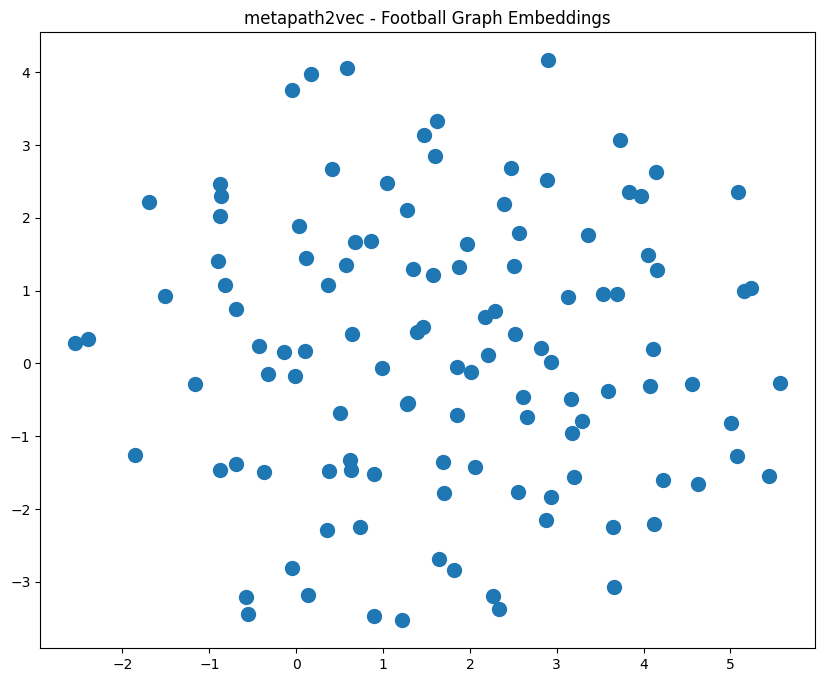

In [4]:
def visualize_embeddings(embeddings):
    tsne = TSNE(n_components=2, random_state=42)
    embeddings_2d = tsne.fit_transform(embeddings)
    plt.figure(figsize=(10, 8))
    plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], cmap='coolwarm', s=100)
    plt.title("metapath2vec - Football Graph Embeddings")
    plt.show()

for node in G.nodes():
    if 'team' in node:
        G.nodes[node]['type'] = 'team'
    else:
        G.nodes[node]['type'] = 'game'

# Train Metapath2Vec model
metapath2vec = Metapath2Vec(G, "football_embeddings.txt", vector_size=128, window=5, min_count=1, workers=4, iter=10, negative=5, alpha=0.025)
metapath2vec.read_sentences()
metapath2vec.train()

# Load embeddings for visualization
embeddings = []
with open("football_embeddings.txt", 'r') as file:
    next(file)  # Skip header
    for line in file:
        parts = line.strip().split()
        embeddings.append(np.array(parts[1:], dtype=float))
embeddings = np.array(embeddings)

# Visualize the embeddings
visualize_embeddings(embeddings)

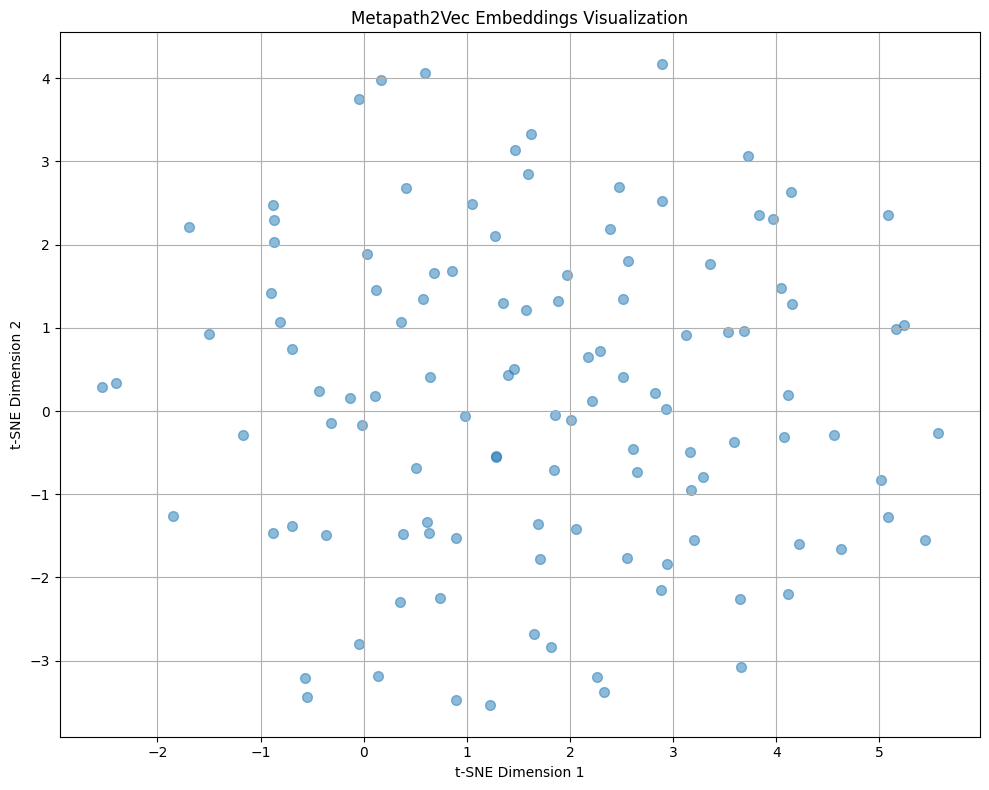

In [5]:
# Function to visualize embeddings in 2D
def visualize_embeddings(embeddings):
    # Perform dimensionality reduction using t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    embeddings_2d = tsne.fit_transform(embeddings)
    
    # Plot the embeddings
    plt.figure(figsize=(10, 8))
    plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], s=50, alpha=0.5)
    plt.title("Metapath2Vec Embeddings Visualization")
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Load embeddings from file
embeddings = []
with open("football_embeddings.txt", 'r') as file:
    next(file)  # Skip header
    for line in file:
        parts = line.strip().split()
        embeddings.append(np.array(parts[1:], dtype=float))
embeddings = np.array(embeddings)

# Visualize the embeddings
visualize_embeddings(embeddings)

# Are Meta-Paths Necessary?: Revisiting Heterogeneous Graph Embeddings (JUST)

### Word2Vec

In [6]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import math
from collections import defaultdict
from tqdm import tqdm
import numpy as np
from sklearn.manifold import TSNE

class Word2Vec:
    def __init__(self, size=100, window=5, negative=5, alpha=0.025, min_count=1, sg=1, iter=5, num_threads=4):
        self.size = size
        self.window = window
        self.negative = negative
        self.alpha = alpha
        self.iter = iter
        self.min_count = min_count
        self.vocab = defaultdict(int)
        self.table = None
        self.table_size = int(1e8)

    def build_vocab(self, sentences):
        for sentence in sentences:
            for word in sentence:
                self.vocab[word] += 1

        self.index2word = [word for word, count in self.vocab.items() if count >= self.min_count]
        self.word2index = {word: idx for idx, word in enumerate(self.index2word)}

        print(f"Vocabulary size: {len(self.vocab)}")
        print(f"Filtered vocabulary size: {len(self.index2word)}")

    def init_weights(self):
        vocab_size = len(self.index2word)
        self.syn0 = np.random.uniform(-0.5 / self.size, 0.5 / self.size, (vocab_size, self.size))
        self.syn1neg = np.zeros((vocab_size, self.size))

    def train(self, sentences):
        self.build_vocab(sentences)
        self.init_weights()

        for i in tqdm(range(self.iter), desc="Training"):
            self.train_epoch(sentences)

    def train_epoch(self, sentences):
        for sentence in sentences:
            for i, word in enumerate(sentence):
                if word not in self.word2index:
                    continue
                word_idx = self.word2index[word]
                start = max(0, i - self.window)
                end = min(len(sentence), i + self.window + 1)
                for j in range(start, end):
                    if j != i:
                        context_word = sentence[j]
                        if context_word in self.word2index:
                            context_idx = self.word2index[context_word]
                            self.train_pair(word_idx, context_idx)

    def train_pair(self, word_idx, context_idx):
        l1 = self.syn0[word_idx]
        l2 = self.syn1neg[context_idx]

        product = np.dot(l1, l2)
        g = self.alpha * (1 - product)

        self.syn0[word_idx] += g * l2
        self.syn1neg[context_idx] += g * l1

    def get_embeddings(self):
        return {word: self.syn0[idx] for word, idx in self.word2index.items()}




### JUST model

In [7]:
import random
import math

# Function to generate a random walk of a given length on a graph G
# G: Graph object
# path_length: Desired length of the random walk
# heterg_dictionary: Dictionary containing heterogeneous types for each homogeneous type
# alpha: Probability parameter for heterogeneous transition
# start: Starting node for the random walk, default is None
def random_walk_generation(G, path_length, heterg_dictionary, alpha, start=None):
    # Initialize the path with the starting node
    path = [start]
    # Initialize the length of homogeneous sequence
    homog_length = 1
    # Initialize flag to indicate if there are no next types available
    no_next_types = False
    
    # Continue the random walk until the path reaches the desired length or no next types available
    while len(path) < path_length and not no_next_types:
        # Get the current node in the path
        cur = path[-1]
        # Get the homogeneous type of the current node
        homog_type = G.nodes[cur]['type']
        # Get the heterogeneous types corresponding to the homogeneous type
        heterg_type = heterg_dictionary.get(homog_type, [])
        
        # Calculate the probability of transitioning to a heterogeneous type
        heterg_probability = 1 - math.pow(alpha, homog_length)
        # Generate a random number between 0 and 1
        r = random.uniform(0, 1)
        # Initialize list to store next type options
        next_type_options = []

        # Check if a heterogeneous transition occurs based on the probability
        if r <= heterg_probability:
            # Add nodes of heterogeneous types to next type options
            for ht in heterg_type:
                next_type_options.extend([e for e in G[cur] if G.nodes[e]['type'] == ht])
            # If no next type options available, fallback to nodes of homogeneous type
            if not next_type_options:
                next_type_options = [e for e in G[cur] if G.nodes[e]['type'] == homog_type]
        else:
            # Add nodes of homogeneous type to next type options
            next_type_options = [e for e in G[cur] if G.nodes[e]['type'] == homog_type]
            # If no next type options available, try nodes of heterogeneous types
            if not next_type_options:
                for ht in heterg_type:
                    next_type_options.extend([e for e in G[cur] if G.nodes[e]['type'] == ht])
        
        # If no next type options available, set flag to True
        if not next_type_options:
            no_next_types = True
        else:
            # Choose a random next node from the available options
            next_node = random.choice(next_type_options)
            path.append(next_node)
            # Update homogeneous sequence length
            if G.nodes[next_node]['type'] == G.nodes[cur]['type']:
                homog_length += 1
            else:
                homog_length = 1
    
    return path

# Function to generate multiple random walks on a graph
# G: Graph object
# num_walks: Number of random walks to generate
# walk_length: Length of each random walk
# heterg_dictionary: Dictionary containing heterogeneous types for each homogeneous type
# alpha: Probability parameter for heterogeneous transition
def generate_walks(G, num_walks, walk_length, heterg_dictionary, alpha):
    print("Generating walks ..")
    walks = []
    nodes = list(G.nodes())
    
    # Generate random walks for each node in the graph
    for _ in range(num_walks):
        # Shuffle the order of nodes to start walks from different nodes
        random.shuffle(nodes)
        for node in nodes:
            # Generate a random walk starting from the current node
            walk = random_walk_generation(G, walk_length, heterg_dictionary, alpha, start=node)
            walks.append(walk)
    print("Walks done ..")
    return walks

# Function to generate node types from a file and create a dictionary
# node_types_file: Path to the file containing node types information
def generate_node_types(node_types_file):
    heterg_dictionary = {}
    with open(node_types_file) as f:
        # Read each line in the file
        for line in f:
            # Split the line to get node type and corresponding heterogeneous types
            node_type, hete_values = line.strip().split(":")
            # Create a dictionary entry with node type as key and list of heterogeneous types as value
            heterg_dictionary[node_type] = hete_values.split(",")
    return heterg_dictionary


### Generate node embeddings using JUST and visualize the embedddings

Generating walks ..
Walks done ..
Vocabulary size: 34
Filtered vocabulary size: 34


Training: 100%|██████████| 10/10 [00:00<00:00, 35.97it/s]


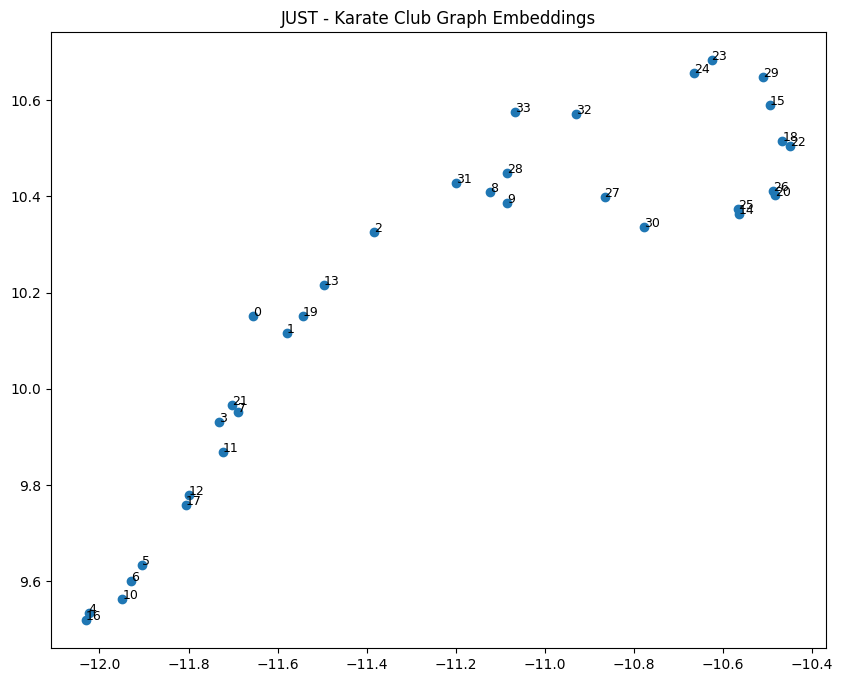

In [8]:
def visualize_walks(G, walks):
    pos = nx.spring_layout(G)
    plt.figure(figsize=(8, 6))
    
    # Draw the graph
    nx.draw(G, pos, node_color='lightblue', node_size=500, edge_color='gray')

    # Draw the walks
    for walk in walks:
        walk_edges = [(walk[i], walk[i+1]) for i in range(len(walk)-1)]
        nx.draw_networkx_edges(G, pos, edgelist=walk_edges, edge_color='red', width=2)

    plt.title("Random Walks on Karate Club Graph")
    plt.show()

def visualize_embeddings(embeddings):
    labels = list(embeddings.keys())
    X = np.array([embeddings[label] for label in labels])

    tsne = TSNE(n_components=2, random_state=42)
    X_tsne = tsne.fit_transform(X)

    plt.figure(figsize=(10, 8))
    plt.scatter(X_tsne[:, 0], X_tsne[:, 1])

    for i, label in enumerate(labels):
        plt.annotate(label, (X_tsne[i, 0], X_tsne[i, 1]), fontsize=9)
    
    plt.title("JUST - Karate Club Graph Embeddings")
    plt.show()

G = nx.karate_club_graph()
for node in G.nodes():
    G.nodes[node]['type'] = random.choice(['A', 'B', 'C'])

# Create a sample node types file
node_types_file = "node_types.txt"
with open(node_types_file, "w") as f:
    f.write("A:B,C\nB:A,C\nC:A,B\n")

# Generate node types dictionary
heterg_dictionary = generate_node_types(node_types_file)

# Generate random walks
walks = generate_walks(G, num_walks=5, walk_length=10, heterg_dictionary=heterg_dictionary, alpha=0.5)

# Flatten walks for Word2Vec training
flattened_walks = [[str(node) for node in walk] for walk in walks]

# Train Word2Vec model
w2v_model = Word2Vec(size=128, window=5, iter=10)
w2v_model.train(flattened_walks)

# Get the embeddings
embeddings = w2v_model.get_embeddings()

# Visualize the embeddings using t-SNE
visualize_embeddings(embeddings)

# BHIN2vec: Balancing the Type of Relation in Heterogeneous Information Network


### SkipGram and BHIN2Vec

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SkipGramModel(nn.Module):
    def __init__(self, node_num, dim, l, k, m):
        super().__init__()
        # Initialize node embeddings with normal distribution
        self.node_embedding = nn.Embedding(node_num, dim)
        nn.init.normal_(self.node_embedding.weight.data, std=0.1)
        # Store parameters
        self.dim = dim
        self.l = l
        self.k = k
        self.m = m

    def forward(self, walk, negative):
        # Extract positive samples from the random walk
        positive = torch.cat([walk[:, i + 1:(i + self.k + 1)] for i in range(self.l - self.k)], dim=1)
        positive = positive.view(-1, self.l - self.k, self.k)
        # Get embeddings for nodes in the walk
        walk = self.node_embedding(walk[:, :(self.l - self.k)])
        # Get embeddings for positive samples
        positive = self.node_embedding(positive).permute(0, 1, 3, 2)
        # Get embeddings for negative samples
        negative = self.node_embedding(negative).permute(0, 1, 3, 2)
        # Reshape tensors for matrix multiplication
        walk = walk.view(-1, 1, self.dim)
        positive = positive.view(-1, self.dim, self.k)
        negative = negative.view(-1, self.dim, self.k * self.m)
        # Perform matrix multiplication
        pos = torch.bmm(walk, positive)
        neg = torch.bmm(walk, negative)
        # Reshape tensors to original shape
        pos = pos.view(-1, self.l - self.k, self.k)
        neg = neg.view(-1, self.l - self.k, self.k * self.m)
        return pos, neg
    
def negative_sampling_loss(pos, neg):
    pos_loss = -torch.mean(torch.log(torch.sigmoid(pos)))
    neg_loss = -torch.mean(torch.log(torch.sigmoid(-neg)))
    return pos_loss + neg_loss

### Generate node embeddings using BHIN2Vec and visualize the embedddings

Epoch 1, Total Loss: 46687.9921875
Epoch 2, Total Loss: 46053.80078125
Epoch 3, Total Loss: 45402.66796875
Epoch 4, Total Loss: 44741.2421875
Epoch 5, Total Loss: 44091.5078125
Epoch 6, Total Loss: 43488.9921875
Epoch 7, Total Loss: 42976.9609375
Epoch 8, Total Loss: 42597.57421875
Epoch 9, Total Loss: 42370.078125
Epoch 10, Total Loss: 42274.953125
Edge type: 0-17, Loss: 1.0261530876159668
Edge type: 1-5, Loss: 1.2603044509887695
Edge type: 2-24, Loss: 1.2100436687469482
Edge type: 3-1, Loss: 1.3377152681350708
Edge type: 4-12, Loss: 1.3485727310180664
Edge type: 5-7, Loss: 1.1536831855773926
Edge type: 6-16, Loss: 1.1527811288833618
Edge type: 7-32, Loss: 1.1059935092926025
Edge type: 8-0, Loss: 1.1943306922912598
Edge type: 9-14, Loss: 1.1770274639129639
Edge type: 10-9, Loss: 1.214153528213501
Edge type: 11-31, Loss: 1.3829386234283447
Edge type: 12-31, Loss: 1.4660542011260986
Edge type: 13-29, Loss: 1.487880825996399
Edge type: 14-0, Loss: 1.2308498620986938
Edge type: 15-1, Loss

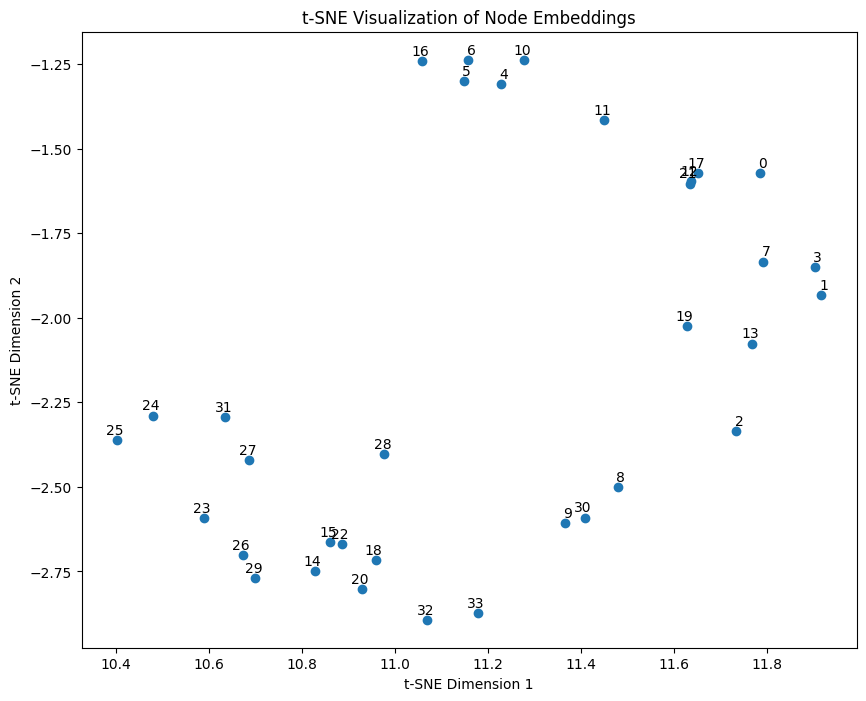

In [10]:
import torch
import numpy as np
import networkx as nx
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Generate or load the graph
G = nx.karate_club_graph()

# Preprocess the graph
node2idx = {node: idx for idx, node in enumerate(G.nodes())}
idx2node = {idx: node for node, idx in node2idx.items()}

# Generate random walks
walks = []
walk_length = 10
num_walks = 1000
for _ in range(num_walks):
    for node in G.nodes():
        walk = [node]
        for _ in range(walk_length - 1):
            neighbors = list(G.neighbors(walk[-1]))
            walk.append(np.random.choice(neighbors))
        walks.append(walk)

walks = np.array(walks)

# Convert walks to tensor
walks_tensor = torch.tensor(walks, dtype=torch.long)

# Generate negative samples
negative_samples = np.random.choice(list(G.nodes()), size=(walks.shape[0], walks.shape[1] - 5, 5 * 5), replace=True)
negative_samples_tensor = torch.tensor(negative_samples, dtype=torch.long)

# Initialize and train the SkipGramModel
node_num = len(G.nodes())
dim = 128
l = 10
k = 5
m = 5

model = SkipGramModel(node_num, dim, l, k, m)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Negative sampling loss function
def negative_sampling_loss(pos, neg):
    pos_loss = -torch.mean(torch.log(torch.sigmoid(pos)))
    neg_loss = -torch.mean(torch.log(torch.sigmoid(-neg)))
    return pos_loss + neg_loss

# Initialize edge losses
edge_losses = {}
epochs = 10
# Training loop
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    
    # Generate positive and negative pairs
    pos, neg = model(walks_tensor, negative_samples_tensor)
    
    # Calculate the loss for each edge type
    total_loss = 0.0
    for i in range(len(pos)):
        pos_loss = -torch.mean(torch.log(torch.sigmoid(pos[i])))
        neg_loss = -torch.mean(torch.log(torch.sigmoid(-neg[i])))
        edge_type = str(idx2node[walks_tensor[i][0].item()]) + '-' + str(idx2node[walks_tensor[i][-1].item()])
        edge_losses[edge_type] = (pos_loss + neg_loss).item()
        total_loss += pos_loss + neg_loss
    
    # Backpropagation
    total_loss.backward()
    optimizer.step()
    
    print(f'Epoch {epoch + 1}, Total Loss: {total_loss.item()}')

# Print edge losses
for edge_type, loss in edge_losses.items():
    print(f'Edge type: {edge_type}, Loss: {loss}')

# Obtain node embeddings
node_embeddings = model.node_embedding.weight.detach().numpy()

# Visualize node embeddings using t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
node_embeddings_tsne = tsne.fit_transform(node_embeddings)

# Plot t-SNE visualization
plt.figure(figsize=(10, 8))
plt.scatter(node_embeddings_tsne[:, 0], node_embeddings_tsne[:, 1])
for i in range(len(G.nodes())):
    plt.annotate(idx2node[i], xy=(node_embeddings_tsne[i, 0], node_embeddings_tsne[i, 1]), xytext=(5, 2),
                 textcoords='offset points', ha='right', va='bottom')
plt.title('t-SNE Visualization of Node Embeddings')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()

# dynnode2vec: Scalable Dynamic Network Embedding


### Word2Vec

In [11]:
class Word2Vec:
    def __init__(self, sentences=None, size=100, vector_size=100, seed=0, workers=4, window=5, negative=5, alpha=0.025, min_count=1, sg=1, iter=5, num_threads=4):
        self.sentences = sentences
        self.size = size
        self.window = window
        self.negative = negative
        self.alpha = alpha
        self.iter = iter
        self.min_count = min_count
        self.sg = sg
        self.num_threads = num_threads
        self.vocab = defaultdict(int)
        self.table = None
        self.table_size = int(1e8)
        self.syn0 = None
        self.syn1neg = None
        self.vector_size = vector_size
        self.seed = seed
        self.workers = workers

    def build_vocab(self):
        for sentence in self.sentences:
            for word in sentence:
                self.vocab[word] += 1

        self.index2word = [word for word, count in self.vocab.items() if count >= self.min_count]
        self.word2index = {word: idx for idx, word in enumerate(self.index2word)}

        print(f"Vocabulary size: {len(self.vocab)}")
        print(f"Filtered vocabulary size: {len(self.index2word)}")

    def train(self):
        self.build_vocab()
        self.init_weights()
        self.train_process()

    def init_weights(self):
        vocab_size = len(self.index2word)
        self.syn0 = np.random.uniform(-0.5 / self.size, 0.5 / self.size, (vocab_size, self.size))
        self.syn1neg = np.zeros((vocab_size, self.size))

    def train_process(self):
        for i in tqdm(range(self.iter), desc="Training"):
            for sentence in self.sentences:
                self.train_epoch(sentence)

    def train_epoch(self, sentence):
        for i, word in enumerate(sentence):
            if word not in self.word2index:
                continue
            word_idx = self.word2index[word]
            start = max(0, i - self.window)
            end = min(len(sentence), i + self.window + 1)
            for j in range(start, end):
                if j != i:
                    context_word = sentence[j]
                    if context_word in self.word2index:
                        context_idx = self.word2index[context_word]
                        self.train_pair(word_idx, context_idx)

    def train_pair(self, word_idx, context_idx):
        l1 = self.syn0[word_idx]
        l2 = self.syn1neg[context_idx]

        product = np.dot(l1, l2)
        g = self.alpha * (1 - product)

        self.syn0[word_idx] += g * l2
        self.syn1neg[context_idx] += g * l1

    def get_embeddings(self):
        return {word: self.syn0[idx] for word, idx in self.word2index.items()}


### Node2Vec

In [12]:
import numpy as np
import random
from collections import defaultdict
from tqdm import tqdm

class Node2Vec:
    def __init__(self, graph, dimensions=128, walk_length=80, num_walks=10, p=1, q=1, workers=1):
        """
        Initiates the Node2Vec object, precomputes walking probabilities and generates the walks.
        """
        self.graph = graph
        for i in range(len(self.graph)):
            self.graph[i, i] = 0
        self.dimensions = dimensions
        self.walk_length = walk_length
        self.num_walks = num_walks
        self.p = p
        self.q = q
        self.workers = workers
        self.first_walk_probability = np.zeros(graph.shape)  # [current, destination]
        self.walk_probability = np.zeros((len(graph), len(graph), len(graph)))  # [last, current, destination]

        self._precompute_probabilities()
        self.walks = self._generate_walks()

    def _precompute_probabilities(self):
        """
        Precomputes transition probabilities for each node.
        """
        print(' Computing prob for first walk...')
        sum_weight = np.sum(self.graph, axis=1)
        sum_weight = np.where(sum_weight == 0, 1, sum_weight)
        normalized_weight = self.graph / np.tile(sum_weight, (len(self.graph), 1)).T
        self.first_walk_probability = normalized_weight

        print(' Computing prob for second walk...')
        for last in range(len(self.graph)):
            for current in range(len(self.graph)):
                if self.graph[last, current] == 0:
                    continue
                unbiased_unnormalized_weight = self.graph[current, :]
                for destination in range(len(self.graph)):
                    if destination == last:
                        unbiased_unnormalized_weight[last] = unbiased_unnormalized_weight[last] / self.p
                    elif self.graph[last, destination] == 0:
                        unbiased_unnormalized_weight[last] = unbiased_unnormalized_weight[last] / self.q
                biased_normalized_weight = unbiased_unnormalized_weight / np.sum(unbiased_unnormalized_weight)
                self.walk_probability[last, current, :] = biased_normalized_weight

    def _generate_walks(self):
        """
        Generates the random walks which will be used as the skip-gram input.
        :return: List of walks. Each walk is a list of nodes.
        """
        all_walks = []
        for n_walk in range(self.num_walks):
            n_th_walks = []
            for source in range(len(self.graph)):
                walk = [source]
                if np.sum(self.first_walk_probability[source, :]) != 0:
                    first_dest = np.random.choice(np.arange(len(self.graph)), 1, p=self.first_walk_probability[source, :])[0]
                    walk.append(first_dest)
                else:
                    walk = [str(source)]
                    n_th_walks.append(walk)
                    continue

                while len(walk) < self.walk_length:
                    if np.sum(self.walk_probability[walk[-2], walk[-1], :]) != 0:
                        dest = np.random.choice(np.arange(len(self.graph)), 1, p=self.walk_probability[walk[-2], walk[-1], :])[0]
                        walk.append(dest)
                    else:
                        break
                walk = [str(elm) for elm in walk]
                n_th_walks.append(walk)

            random.shuffle(n_th_walks)
            all_walks += n_th_walks
        return all_walks

    def fit(self, initial_wv_file=None, save_wv_file=None, **skip_gram_params):
        """
        Creates the embeddings using the provided Word2Vec class.
        """
        print(' Training skip-gram model...')
        model = Word2Vec(sentences=self.walks, vector_size=self.dimensions, workers=self.workers, **skip_gram_params)
        model.train()

        if save_wv_file:
            with open(save_wv_file, 'w') as f:
                for word, vector in model.get_embeddings().items():
                    f.write(f"{word} {' '.join(map(str, vector))}\n")

        return model

In [13]:
def norm_hic(m):
    # Calculate the average values of the diagonals of the input matrix
    average = [np.mean(np.diag(m[i:, :len(m)-i])) for i in range(len(m))]
    
    # Normalize the matrix based on the calculated averages
    for i in range(len(m)):
        if average[i] == 0:
            continue
        for j in range(len(m)-i):
            # Normalize upper triangular elements
            m[j][j+i] = m[j][j+i] / average[i]
            if i != 0:
                # If not on the main diagonal, normalize lower triangular elements
                m[j+i][j] = m[j+i][j] / average[i]
    return m


### Identify temporal changes between two graphs


In [14]:
def get_temporal_changes(graph1, graph2):
    changes = np.where(graph1 != graph2)
    return set(changes[0]).union(set(changes[1]))

### dynnode2vec model

In [15]:
def dynnode2vec(graphs, epochs):
    tot_c = len(graphs) * epochs  # Total number of training iterations
    cnt = 0  # Counter to keep track of the current iteration

    for epoch in range(epochs):  # Loop through each epoch
        for i, graph in enumerate(graphs):  # Loop through each graph
            cnt += 1
            print(f'Training model: {cnt} / {tot_c}')

            # Initialize Node2Vec with the current graph
            n2v = Node2Vec(graph, dimensions=16, walk_length=80, num_walks=15, p=1, q=1, workers=8)

            # Model initialization based on conditions (to be filled later)
            if i == 0 and epoch == 0:
                # First iteration, train model from scratch and save embeddings
                model = n2v.fit(save_wv_file='./temp/wv_0.emb', min_count=1, window=3)
            elif i == 0:
                # First graph of the current epoch, initialize from the last graph of the previous epoch
                model = n2v.fit(initial_wv_file=f'./temp/wv_{len(graphs) - 1}.emb', save_wv_file=f'./temp/wv_{i}.emb', min_count=1, window=2)
            else:
                # For subsequent graphs, initialize from the previous graph's embeddings
                model = n2v.fit(initial_wv_file=f'./temp/wv_{i - 1}.emb', save_wv_file=f'./temp/wv_{i}.emb', min_count=1, window=2)
            if i < len(graphs) - 1:
                # Identify nodes with changes between the current and next graph
                changes = get_temporal_changes(graph, graphs[i + 1])
                # Filter walks to include only those with nodes that have changed
                n2v.walks = [walk for walk in n2v.walks if any(node in changes for node in walk)]

            # Print n2v.walks after each iteration
            print("Walks:", n2v.walks)
    return model



### Generate node embeddings using dynnode2vec and visualize the embedddings

Training model: 1 / 1
 Computing prob for first walk...
 Computing prob for second walk...
 Training skip-gram model...
Vocabulary size: 34
Filtered vocabulary size: 34


Training: 100%|██████████| 5/5 [00:02<00:00,  1.94it/s]

Walks: [['33', '19', '0', '8', '0', '11', '0', '7', '2', '1', '17', '0', '2', '7', '3', '7', '3', '1', '7', '2', '7', '3', '12', '3', '12', '0', '21', '0', '17', '0', '8', '2', '13', '3', '7', '2', '13', '0', '21', '0', '19', '1', '3', '1', '17', '1', '2', '1', '3', '12', '3', '13', '0', '13', '1', '21', '0', '11', '0', '21', '1', '19', '33', '31', '0', '10', '5', '6', '16', '6', '16', '5', '0', '21', '0', '8', '0', '17', '0', '11'], ['22', '32', '30', '32', '18', '33', '15', '32', '33', '27', '24', '31', '24', '31', '28', '2', '7', '0', '19', '0', '17', '1', '17', '1', '17', '1', '13', '2', '32', '14', '33', '22', '32', '30', '33', '22', '33', '26', '29', '26', '33', '18', '33', '27', '23', '29', '32', '8', '30', '33', '20', '32', '23', '32', '33', '19', '0', '19', '0', '8', '0', '5', '0', '13', '0', '21', '0', '13', '33', '19', '0', '21', '0', '21', '0', '8', '0', '8', '0', '12'], ['8', '0', '8', '0', '8', '32', '8', '0', '6', '16', '6', '16', '6', '5', '6', '16', '5', '6', '5', '16'

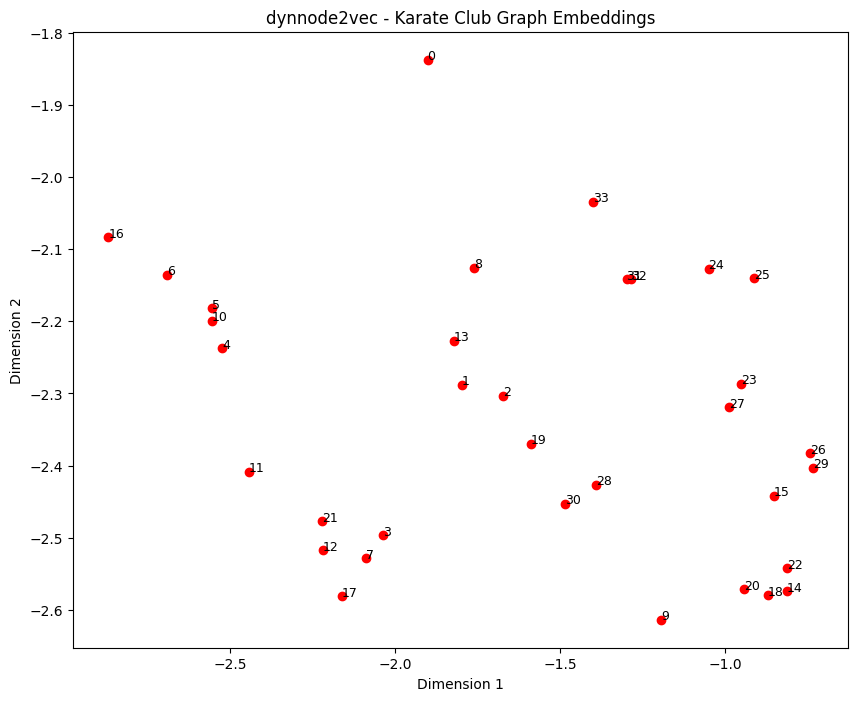

In [16]:
import os
from sklearn.manifold import TSNE
import networkx as nx
import matplotlib.pyplot as plt

# Create the temp directory if it doesn't exist
os.makedirs('./temp', exist_ok=True)

# Load the Karate Club graph
G = nx.karate_club_graph()

# Get the adjacency matrix and normalize it
adj_matrix = nx.to_numpy_array(G)
norm_adj_matrix = norm_hic(adj_matrix.copy())

# Create a list of graphs (only one in this case)
graphs = [norm_adj_matrix]

# Run Node2Vec
model = dynnode2vec(graphs, epochs=1)

# Extract embeddings
embeddings = model.get_embeddings()
nodes = list(embeddings.keys())
vectors = np.array([embeddings[node] for node in nodes])

# Use t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=0)
reduced_embeddings = tsne.fit_transform(vectors)

# Visualize the embeddings
plt.figure(figsize=(10, 8))
for i, node in enumerate(nodes):
    plt.scatter(reduced_embeddings[i, 0], reduced_embeddings[i, 1], c='red')
    plt.text(reduced_embeddings[i, 0], reduced_embeddings[i, 1], str(node), fontsize=9)
plt.title('dynnode2vec - Karate Club Graph Embeddings')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()


# Continuous-Time Dynamic Network Embeddings (CTDNE)

### Word2Vec

In [17]:
class Word2Vec:
    def __init__(self, size=100, window=5, negative=5, alpha=0.025, min_count=1, sg=1, iter=5, num_threads=4):
        self.size = size
        self.window = window
        self.negative = negative
        self.alpha = alpha
        self.min_count = min_count
        self.sg = sg
        self.iter = iter
        self.num_threads = num_threads
        self.vocab = defaultdict(int)
        self.index2word = []
        self.word2index = {}
        self.syn0 = None
        self.syn1neg = None
        self.table = None
        self.table_size = int(1e8)

    def build_vocab(self, sentences):
        for sentence in sentences:
            for word in sentence:
                self.vocab[word] += 1

        self.index2word = [word for word, count in self.vocab.items() if count >= self.min_count]
        self.word2index = {word: idx for idx, word in enumerate(self.index2word)}

        print(f"Vocabulary size: {len(self.vocab)}")
        print(f"Filtered vocabulary size: {len(self.index2word)}")

    def init_weights(self):
        vocab_size = len(self.index2word)
        self.syn0 = np.random.uniform(-0.5 / self.size, 0.5 / self.size, (vocab_size, self.size))
        self.syn1neg = np.zeros((vocab_size, self.size))

    def train(self, sentences):
        self.build_vocab(sentences)
        self.init_weights()

        for i in tqdm(range(self.iter), desc="Training"):
            self.train_epoch(sentences)

    def train_epoch(self, sentences):
        for sentence in sentences:
            for i, word in enumerate(sentence):
                if word not in self.word2index:
                    continue
                word_idx = self.word2index[word]
                start = max(0, i - self.window)
                end = min(len(sentence), i + self.window + 1)
                for j in range(start, end):
                    if j != i:
                        context_word = sentence[j]
                        if context_word in self.word2index:
                            context_idx = self.word2index[context_word]
                            self.train_pair(word_idx, context_idx)

    def train_pair(self, word_idx, context_idx):
        l1 = self.syn0[word_idx]
        l2 = self.syn1neg[context_idx]

        product = np.dot(l1, l2)
        g = self.alpha * (1 - product)

        self.syn0[word_idx] += g * l2
        self.syn1neg[context_idx] += g * l1

    def get_embeddings(self):
        return {word: self.syn0[idx] for word, idx in self.word2index.items()}

### CTDNE model

In [18]:
import networkx as nx
import numpy as np
import pickle
import random

class TimeGraph:
    def __init__(self, graph, time_prop_name):
        self.G = graph
        self.time_prop_name = time_prop_name
        self.edges = list(self.G.edges(data=True))

        self.beta = None  # number of temporal context windows
        self.D = None  # embedding dimension 128
        self.L = None  # max walk length
        self.omega = None  # min walk length / context window size for skip gram

        self.all_time_walks = None
        self.num_nodes = len(list(self.G.nodes()))
        self.num_edges = len(self.edges)

    def set_temporal_walk_params(self, beta, D, omega, L=80):
        self.beta = beta
        self.D = D
        self.L = L
        self.omega = omega

    def sample_edge(self):
        num_edges = len(self.edges)
        choice = np.random.choice(num_edges)
        return self.edges[choice]

    def generate_ctdne_walks(self):  # Algorithm 1 from CTDNE paper
        # collection of random walks
        all_time_walks = []

        # initialize number of context windows
        C = 0
        counter = 0
        while self.beta - C > 0:
            u, v, prop = self.sample_edge()
            t = prop[self.time_prop_name]

            walk_t = self._temporal_walk(start_edge=(u, v), t=t, C=self.omega + self.beta - C - 1)
            if (walk_t is not None) and (len(walk_t) >= self.omega):
                all_time_walks.append(walk_t)
                C = C + (len(walk_t) - self.omega + 1)

            counter += 1
            if (counter + 1) % 1000 == 0:
                print('Loop ran for ', counter + 1, 'times!\t Current C = ', C)

        self.all_time_walks = all_time_walks

    def _temporal_walk(self, start_edge=None, t=None, C=0):  # Algorithm 2 from CTDNE
        """ Returns a random walk that respects time
            start: the start node of the random walk.
        """
        G = self.G
        prop_name = self.time_prop_name

        if start_edge:
            path = [start_edge[0], start_edge[1]]
        else:
            raise ValueError('start_edge should not be None.')

        curr_node = start_edge[1]

        for p in range(1, min(self.L, C)):
            # select next nodes whose time (curr_node, next_node) is greater than t
            neighbor_candidates = []
            for u, v, prop in G.edges(curr_node, data=True):
                if prop[prop_name] >= t:
                    neighbor_candidates.append((v, prop[prop_name]))

            # check if there are valid neighbors to walk to
            if len(neighbor_candidates) > 0:
                # set new current node & t
                idx_next_node = np.random.choice(range(len(neighbor_candidates)))
                curr_node, t = neighbor_candidates[idx_next_node]

                # add new current node to path
                path.append(curr_node)
            else:
                break
        return path


### Save temporal random walk to pkl file

In [19]:
def main():
    graph = nx.karate_club_graph()
    # Assigning random time values for demonstration purposes
    for u, v in graph.edges():
        graph[u][v]['time'] = random.randint(0, 100)

    path = 'karate_club_walks.pkl'

    timeG = TimeGraph(graph, 'time')

    R = 80
    N = timeG.num_nodes
    omega = 10
    L = 80
    beta = R * N * (L - omega + 1)

    print("Beta value:", beta)

    print("Started Walk...")

    timeG.set_temporal_walk_params(beta=beta, D=128, omega=omega, L=L)
    timeG.generate_ctdne_walks()

    ctdne_walks = timeG.all_time_walks

    with open(path, 'wb') as f:
        pickle.dump(ctdne_walks, f)


if __name__ == '__main__':
    main()

Beta value: 193120
Started Walk...
Loop ran for  1000 times!	 Current C =  71928
Loop ran for  2000 times!	 Current C =  143928


### Generate node embeddings using CTDNE and visualize the embedddings

Vocabulary size: 34
Filtered vocabulary size: 34


Training: 100%|██████████| 5/5 [00:22<00:00,  4.46s/it]


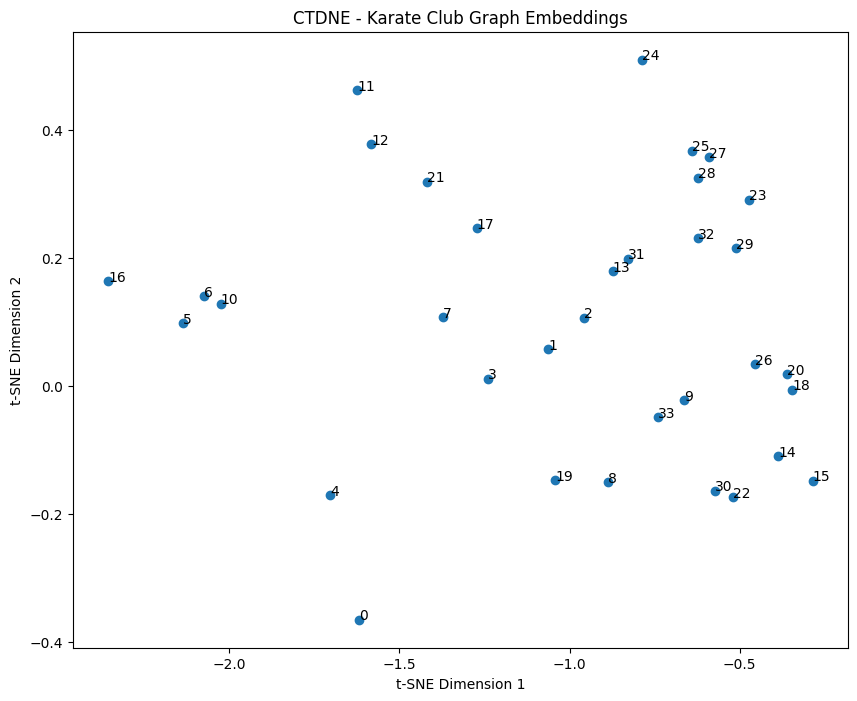

In [20]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Load karate club walks
with open("karate_club_walks.pkl", "rb") as f:
    karate_club_walks = pickle.load(f)

# Generate karate club graph
graph = nx.karate_club_graph()

# Train Word2Vec model
w2v_model = Word2Vec(size=128)
w2v_model.train(karate_club_walks)

# Get node embeddings
node_embeddings = w2v_model.get_embeddings()

# Convert embeddings to numpy array
node_embeddings_np = np.array(list(node_embeddings.values()))

# Apply t-SNE for visualization
tsne = TSNE(n_components=2, random_state=42)
node_embeddings_tsne = tsne.fit_transform(node_embeddings_np)

# Visualize node embeddings
plt.figure(figsize=(10, 8))
plt.scatter(node_embeddings_tsne[:, 0], node_embeddings_tsne[:, 1])
for i, txt in enumerate(node_embeddings.keys()):
    plt.annotate(txt, (node_embeddings_tsne[i, 0], node_embeddings_tsne[i, 1]))
plt.title('CTDNE - Karate Club Graph Embeddings')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()